### One Shot Learning com Siamese Networks em PyTorch

As redes siamesas são um tipo especial de arquitetura de rede. Em vez de um modelo aprendendo aclassificarsuas entradas, as redes neurais aprendem adiferenciarentre duas entradas. Ele aprende a semelhança entre eles.

<p align="center">
    <img src="https://miro.medium.com/max/720/1*XzVUiq-3lYFtZEW3XfmKqg.jpeg" alt="sn" width="300"/>
</p>

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Funções Auxiliares

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Importação e pré-processar o conjunto de dados

AT&T faces dataset:

O conjunto de dados contém imagens de 40 pessoas de diferentes ângulos.

In [3]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5)
                                                                      ])
                                       ,should_invert=False)

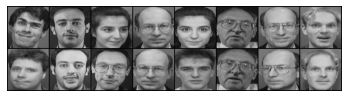

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

#### Modelo

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

<p align="center">
    <img src="https://blog.jaysinha.me/content/images/2021/08/Screenshot-2021-08-30-at-3.19.27-PM.png" alt="sn" width="300"/>
</p>

#### Função de perda

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

#### Treinamento

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.6226844787597656

Epoch number 1
 Current loss 1.932431936264038

Epoch number 2
 Current loss 2.0640265941619873

Epoch number 3
 Current loss 1.7996606826782227

Epoch number 4
 Current loss 1.3734118938446045

Epoch number 5
 Current loss 0.8133000135421753

Epoch number 6
 Current loss 0.2990982234477997

Epoch number 7
 Current loss 0.46761834621429443

Epoch number 8
 Current loss 0.21960540115833282

Epoch number 9
 Current loss 0.33556658029556274

Epoch number 10
 Current loss 0.3016740679740906

Epoch number 11
 Current loss 0.3012361228466034

Epoch number 12
 Current loss 0.30620813369750977

Epoch number 13
 Current loss 0.5623061656951904

Epoch number 14
 Current loss 0.2995380163192749

Epoch number 15
 Current loss 0.14960141479969025

Epoch number 16
 Current loss 0.18082253634929657

Epoch number 17
 Current loss 0.18844567239284515

Epoch number 18
 Current loss 0.12454216927289963

Epoch number 19
 Current loss 0.08363451063632965

Ep

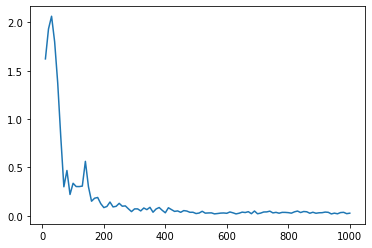

In [13]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

#### Visualização

In [29]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5)
                                                                ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

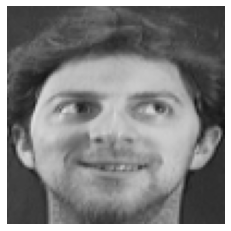

In [30]:
imshow(torchvision.utils.make_grid(x0))

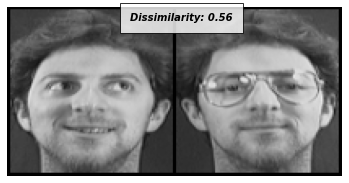

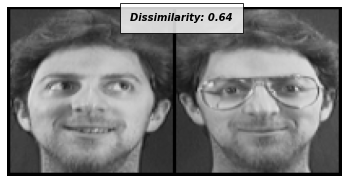

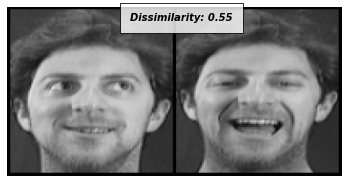

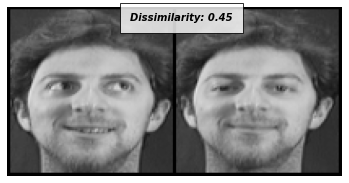

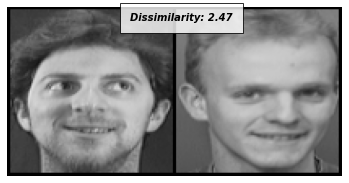

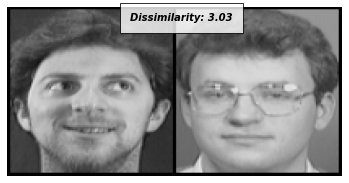

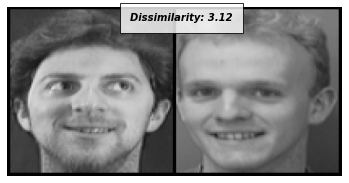

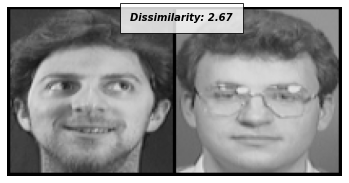

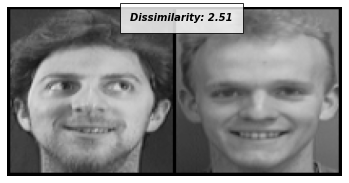

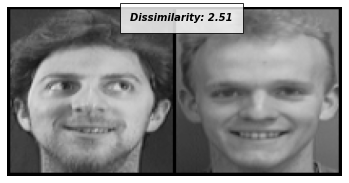

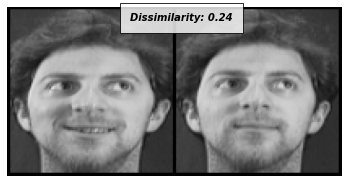

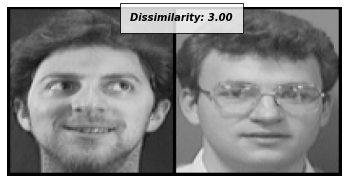

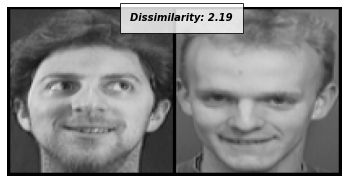

In [31]:
min_distance = 999.9
img_min_distance = []
i = 0;
for element in dataiter:
#for i in range(14):
    if i == 13 and min_distance <= 0.8: break;
    _,x1,label2 = next(dataiter)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    concatenated = torch.cat((x0,x1),0)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    if euclidean_distance.item() < min_distance:
        min_distance = euclidean_distance.item()
        img_min_distance = x1
    i += 1

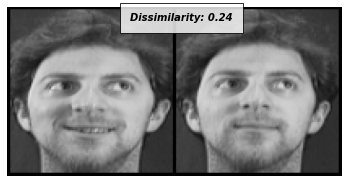

In [32]:
if min_distance < 0.8:
    concatenated = torch.cat((x0,img_min_distance),0)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(min_distance))
else:
    print('unknown face')

#### Referências

1. https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
2. https://medium.com/hackernoon/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e
3. https://blog.jaysinha.me/train-your-first-siamese-neural-network-for-detecting-face-similarity/
4. https://builtin.com/machine-learning/siamese-network
5. https://insightlab.ufc.br/tutorial-pytorch-um-guia-rapido-para-voce-entender-agora-os-fundamentos-do-pytorch